PREDICTION ON THE UPTAKE OF SEASONAL FLU VACCINES

This project aims at developing a predictive model that estimates whether an individual received the seasonal flu vaccine using data from the National 2009 H1N1 Flu Survey. The dataset includes variables such as age, education,income,health status,healthcare access, and perceptions of vaccine safety and effectiveness.

The target variable is Binary: seasonal_vaccine(1 =respondent received the seasonal flu vaccine, 0= did not)

In [15]:
#Importing necessary libraries for preprocessing and modeling
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.impute import SimpleImputer

Loading the dataset

In [16]:
#Load the datasets; features and labels
train_features = pd.read_csv("training_set_features.csv")
train_labels = pd.read_csv("training_set_labels.csv")
test_features = pd.read_csv('test_set_features.csv')

print(train_features.shape,train_labels.shape,test_features.shape)

(26707, 36) (26707, 3) (26708, 36)


In [17]:
#Merging the dataset
train_data = pd.concat([train_features,train_labels],axis=1)
print(train_data.shape)
train_data.head

(26707, 39)


<bound method NDFrame.head of        respondent_id  h1n1_concern  h1n1_knowledge  behavioral_antiviral_meds  \
0                  0           1.0             0.0                        0.0   
1                  1           3.0             2.0                        0.0   
2                  2           1.0             1.0                        0.0   
3                  3           1.0             1.0                        0.0   
4                  4           2.0             1.0                        0.0   
...              ...           ...             ...                        ...   
26702          26702           2.0             0.0                        0.0   
26703          26703           1.0             2.0                        0.0   
26704          26704           2.0             2.0                        0.0   
26705          26705           1.0             1.0                        0.0   
26706          26706           0.0             0.0                        0.0  

In [18]:
#Choosing the Target
y = train_labels['seasonal_vaccine']   #This is the target   (the dependent variable)
X = train_features                     #These are the features   (the independent variables)


Handling of missing Values and Preprocessing

In [19]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


#Spliting categorical and numerical
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(exclude=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols)
    ])

Splitting Data into Training and Validation Sets

In [20]:
#Test spliting and Training the features
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

Modeling

In [21]:
#Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
model = Pipeline(steps = [('preprocessor',preprocessor),
                           ('classifier',LogisticRegression(max_iter =1000, class_weight='balanced'))])
model.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['age_group', 'education', 'race', 'sex', 'income_poverty',
       'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_regio

Evaluation

This will give us the Five Key Metrics that matter most in the binary classification. That is the Accuracy,Precision,Recall,F1-Score and ROC AUC

In [22]:
#Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

y_pred = model.predict(X_val)
y_proba = model.predict_proba(X_val)[:,1]

print("Accuracy:", accuracy_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred))
print("Recall:", recall_score(y_val, y_pred))
print("F1:", f1_score(y_val, y_pred))
print("ROC AUC:", roc_auc_score(y_val, y_proba))

Accuracy: 0.7635092973917385
Precision: 0.7473060344827587
Recall: 0.7435004020369874
F1: 0.7453983608759909
ROC AUC: 0.8389504800345415


Precision V Recall

In [23]:
thresholds =np.arange(0.1,0.9,0.1)
for t in thresholds:
    preds = (y_proba >= t).astype(int)
    print(f"Thresholds {t:.1f} -Precision: {precision_score(y_val,preds):.2f},Recall: {recall_score(y_val,preds):.2f}")

Thresholds 0.1 -Precision: 0.51,Recall: 0.99
Thresholds 0.2 -Precision: 0.57,Recall: 0.95
Thresholds 0.3 -Precision: 0.64,Recall: 0.90
Thresholds 0.4 -Precision: 0.69,Recall: 0.83
Thresholds 0.5 -Precision: 0.75,Recall: 0.74
Thresholds 0.6 -Precision: 0.79,Recall: 0.65
Thresholds 0.7 -Precision: 0.83,Recall: 0.55
Thresholds 0.8 -Precision: 0.88,Recall: 0.40


Determinants (Features) of the Seasonal Flu Vaccine Uptake

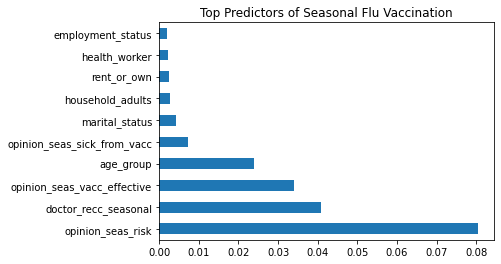

In [24]:
from sklearn.inspection import permutation_importance
result = permutation_importance(model,X_val,y_val,n_repeats=10,random_state=42)
importances = result.importances_mean

feat_importances = pd.Series(importances, index = X.columns).sort_values(ascending=False)
feat_importances.head(10).plot(kind='barh')
plt.title("Top Predictors of Seasonal Flu Vaccination")
plt.show()


The predictor feature being the respondent's opinion about risk of getting sick with seasonal flu without vaccine, and the least determint feature being the employment status.

ROC CURVE

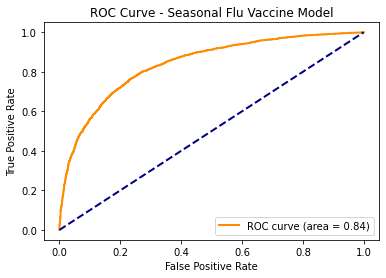

In [25]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_val, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Seasonal Flu Vaccine Model')
plt.legend(loc="lower right")
plt.show()

Explanation of the Curve


Axes:

X-axis (False Positive Rate) → proportion of non-vaccinated people incorrectly predicted as vaccinated.

Y-axis (True PositiveRate/ Recall) → proportion of vaccinated people correctly identified.



This shows the trade-off between sensitivity (recall) and specificity and the closer the curve hugs the top-left corner, the better the model.

The ROC's Area Under the Curve is at 84% which means the model shows strong discrimination ability much better than random guessing.

Confusion Matrix

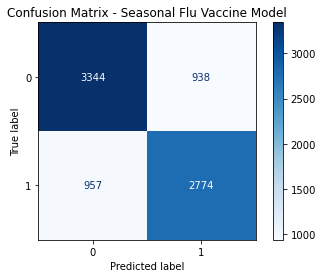

In [26]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Seasonal Flu Vaccine Model")
plt.show()


Interpretation


The diagonal cells show correct predictions while Off-diagonal cells show misclassifications (false positives and false negatives).


This helps in seeing if the model is biased toward predicting one class more often.


The confusion matrix will also reveal whether errors are balanced (missing vaccination vs. predicting vaccination incorrectly).






Predictions for Unseen Data

In [27]:
test_preds =model.predict(test_features)
test_proba =model.predict_proba(test_features)[:,1]
submission = pd. DataFrame({
    "predictions":test_preds,
    "probability": test_proba
})
print(submission.head())

   predictions  probability
0            0     0.288211
1            0     0.056813
2            1     0.683791
3            1     0.938936
4            0     0.434304



Limitations


We used outdated data,the dataset is from 2009, so attitudes and behaviors may not reflect current populations.

Although the metrics look balanced, if one class dominates (e.g., more vaccinated than not),accuracy can be inflated,causing class imbalance.

Association vs. Cause and Effect; this model identifies correlation, not the causal drivers of uptake.

Some important influences (local vaccine supply, cultural factors) aren’t captured in the dataset.